# Hierarchical clustering for portfolio optimization
### This notebook uses the *assets.csv* dataset

In finance, hierarchical clustering is used, among others, to take advantage of hierarchical relationships in order to diversify risk.

This notebook is an example. It does not show an exhaustive detail on all CRISP-DM phases.<br> Some parts adapted from adapted from https://medium.com/@orenji.eirl/hierarchical-clustering-and-networks-with-python-and-riskfolio-lib-dd3f09a5e9af and https://medium.com/@orenji.eirl/hierarchical-equal-risk-contribution-with-python-and-riskfolio-lib-ec45dd0f9899

(c) Nuno António 2022 - Rev. 1.00

### Dataset description

This dataset contains data from 25 assets ('JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM','ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO','DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA') from the period between 2016-01-01 and 2019-30-30, extracted with the package yfinance from Yahoo Finance.

More information on the dataset collection available at https://pypi.org/project/yfinance/

This example uses the riskfolio package. For more information check: https://pypi.org/project/Riskfolio-Lib/<br>
For installation run: pip install Riskfolio-Lib

## Initial setup and modules/packages loading

In [2]:
pip install PyPortfolioOpt

     ---------------------------------------- 0.0/61.9 kB ? eta -:--:--
     ---------------------------------------- 61.9/61.9 kB 1.7 MB/s eta 0:00:00
  Using cached cvxpy-1.3.1-cp39-cp39-win_amd64.whl (889 kB)
  Using cached scs-3.2.3-cp39-cp39-win_amd64.whl (8.2 MB)
  Using cached ecos-2.0.12-cp39-cp39-win_amd64.whl (72 kB)
  Using cached osqp-0.6.3-cp39-cp39-win_amd64.whl (292 kB)
  Using cached qdldl-0.1.7-cp39-cp39-win_amd64.whl (83 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install rpy2

     ---------------------------------------- 0.0/217.8 kB ? eta -:--:--
     ------------------------------------- 217.8/217.8 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [8 lines of output]
  Unable to determine R home.
  Unable to determine R home: [WinError 2] The system cannot find the file specified
  cffi mode is CFFI_MODE.ANY
  Looking for R home with: R RHOME
  Unable to determine R home.
  Unable to determine R home: [WinError 2] The system cannot find the file specified
  R home found: None
  Error: rpy2 in API mode cannot be built without R in the PATH or R_HOME defined. Correct this or force ABI mode-only by defining the environment variable RPY2_CFFI_MODE=ABI
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

Getting requirements to build wheel did not run successfully.
exit code: 1

See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [4]:
install.packages("PortfolioAnalytics")

NameError: name 'install' is not defined

In [5]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy.cluster.vq import whiten
import riskfolio as rp

ModuleNotFoundError: No module named 'riskfolio'

In [2]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

## Data understanding

In [3]:
# Load dataset
ds = pd.read_csv('assets.csv', index_col='Date')
ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 2016-01-04 to 2019-12-27
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   APA     1004 non-null   float64
 1   BA      1004 non-null   float64
 2   BAX     1004 non-null   float64
 3   BMY     1004 non-null   float64
 4   CMCSA   1004 non-null   float64
 5   CNP     1004 non-null   float64
 6   CPB     1004 non-null   float64
 7   DE      1004 non-null   float64
 8   HPQ     1004 non-null   float64
 9   JCI     1004 non-null   float64
 10  JPM     1004 non-null   float64
 11  LUV     1004 non-null   float64
 12  MMC     1004 non-null   float64
 13  MO      1004 non-null   float64
 14  MSFT    1004 non-null   float64
 15  NI      1004 non-null   float64
 16  PCAR    1004 non-null   float64
 17  PSA     1004 non-null   float64
 18  SEE     1004 non-null   float64
 19  T       1004 non-null   float64
 20  TGT     1004 non-null   float64
 21  TMO     1004 non-null   flo

In [4]:
# First rows
ds.head()

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,39.187168,126.005104,34.722965,56.235931,24.789188,14.546505,42.866982,68.003479,9.621540,25.488489,...,16.090399,37.986343,198.488708,39.351032,23.607986,61.950172,136.338989,41.089146,34.719669,23.462406
2016-01-05,38.393372,126.516281,34.863083,57.343361,24.793644,14.681857,43.024632,68.396767,9.712779,25.183813,...,16.345934,37.994408,204.093292,39.735043,23.772932,63.036701,136.103149,41.188156,35.196522,23.207664
2016-01-06,33.983376,124.507385,34.947159,56.336617,24.602077,14.498731,42.949955,67.628067,9.364412,24.943279,...,16.436611,38.002453,204.418198,39.113316,23.738089,62.396584,135.061539,39.950527,34.878548,22.531286
2016-01-07,32.237030,119.287796,34.367970,54.776119,24.330303,14.212103,42.425686,67.029198,8.933102,24.309875,...,16.073915,36.850643,202.290115,37.879028,23.354763,62.228115,131.976135,39.128757,34.686985,21.854908
2016-01-08,32.325226,116.579399,33.816826,53.383450,24.357029,14.180256,42.667782,65.929764,8.775507,24.269789,...,16.049185,36.431789,200.811798,37.824173,23.375673,60.122402,131.828751,38.683193,34.349846,21.608955


In [5]:
# Summary statistics
ds.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
APA,1004.0,38.961281,9.933617,17.915926,32.168873,39.543749,45.493973,60.624680
BA,1004.0,253.661775,99.815590,98.152580,146.006516,282.805389,343.138855,430.299957
BAX,1004.0,60.135547,14.329378,32.471622,45.239102,61.632219,71.557451,87.310890
BMY,1004.0,50.288059,5.625513,39.534908,46.186011,48.914286,54.493787,65.134735
CMCSA,1004.0,34.157010,4.812237,23.858034,30.351112,33.938841,37.184711,44.696335
CNP,1004.0,23.240729,3.531317,13.455716,20.726473,24.071707,25.621352,28.674156
CPB,1004.0,42.630650,6.973653,29.048525,36.547972,42.849865,48.886101,56.665951
DE,1004.0,121.518224,31.927226,64.159935,95.038839,130.268623,149.160950,174.064041
HPQ,1004.0,16.606486,3.851655,7.481577,13.229205,17.506485,19.395483,23.826033
JCI,1004.0,34.868290,3.613410,23.900976,32.395031,35.114822,37.292054,42.260826


In [6]:
# Check which rows have missing values
ds[ds.isnull().any(axis=1)]

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,


## Data preparation

In [7]:
# Calculate the percentage change
X = ds.pct_change().dropna()

## Modeling

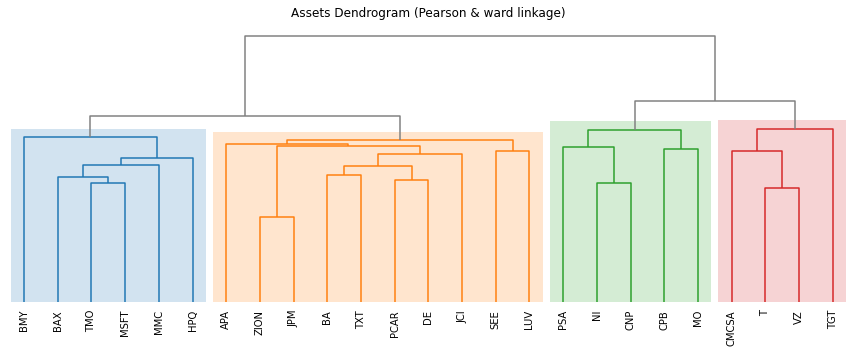

In [8]:
# Plot the dendogram

# Draw
fig, ax = plt.subplots(figsize=(10,10))
dg = rp.plot_dendrogram(returns=X,
                               codependence='pearson',
                               linkage='ward',
                               k=None,
                               max_k=10,
                               leaf_order=True)

In [9]:
# Building the portfolio object
port = rp.HCPortfolio(returns=X)

# Estimate optimal portfolio:

model='HERC'                        # Could be HRP or HERC
rm = 'MV'                           # Risk measure used, this time will be variance
rf = 0                              # Risk free rate
linkage = 'ward'                    # Linkage method used to build clusters
max_k = 10                          # Max number of clusters used in two difference gap statistic
leaf_order = True                   # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# Check weights per asset 
w.T

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.006426,0.017317,0.045549,0.026475,0.058416,0.076425,0.039035,0.017341,0.022539,0.022513,...,0.073706,0.021239,0.06945,0.020177,0.077078,0.031867,0.040487,0.018486,0.08789,0.016276


<AxesSubplot:title={'center':'HERC Naive Risk Parity'}>

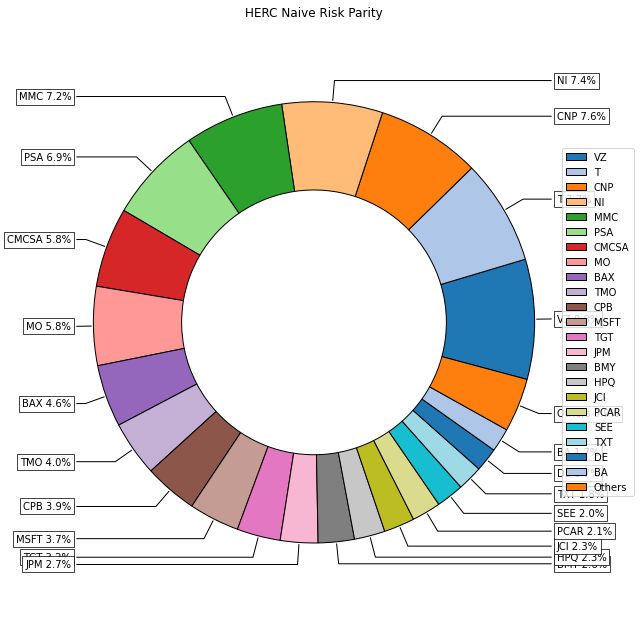

In [10]:
# Plotting the composition of the portfolio
fig, ax = plt.subplots(figsize=(9,9))
rp.PlotFunctions.plot_pie(w=w,
                  title='HERC Naive Risk Parity',
                  others=0.05,
                  nrow=25,
                  cmap="tab20",
                  height=8,
                  width=10,
                  ax=ax)

For additional information on hierarchical clustering check https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html